In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import  seaborn as sns

from utility import utilities

In [2]:
df = pd.read_table('Hippo_2.txt')
df.set_index('Fasta headers',inplace=True)
#rename columns
df.columns = ['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','null']
#print (df.reset_index(drop=True).head())

#remove all zeros rows
print ('before', df.shape)
df = df[(df.T != 0).any()]
print ('after', df.shape)


before (8304, 10)
after (7478, 10)


In [3]:
#visualize reproducibility
#utilities.make_scatter_matrix(np.log1p(df), 'pre_norm_hippo')


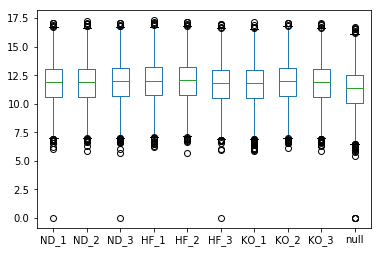

In [4]:
#data distribution before normalization
np.log1p(df).plot(kind='box')
plt.show()

1 0.0582104011203 4.99471883919
2 0.00124949649806 0.152496822387
3 3.57894136834e-05 0.00436790110134
4 1.02274052372e-06 0.000124839488652
5 2.92271864072e-08 3.56768562559e-06
normalized in 5 steps


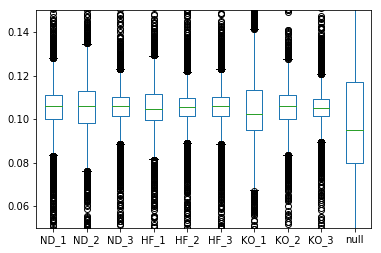

In [5]:
#data distribution after normalization
norm_df = utilities.constandNormalize(df)
np.log1p(norm_df).plot(kind='box')
plt.ylim(0.05,0.15)
plt.show()

[ 0.74173373  0.11451822]


No handles with labels found to put in legend.


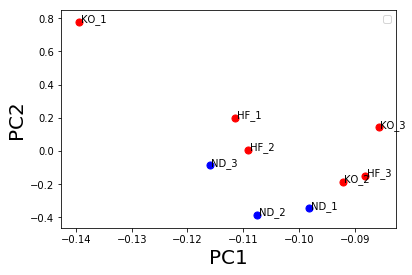

In [6]:
#visualize pca data
utilities.make_pca(norm_df)

In [7]:

#for visualization later
norm_df['mean_ND'] = norm_df[['ND_1','ND_2','ND_3']].median(axis=1)
norm_df['mean_HF'] = norm_df[['HF_1','HF_2','HF_3']].median(axis=1)
norm_df['mean_KO'] = norm_df[['KO_1','KO_2','KO_3']].median(axis=1)

norm_df['log2_fc_HF_ND'] = np.log2(norm_df['mean_HF']/norm_df['mean_ND'])
norm_df['log2_fc_ND_KO'] = np.log2(norm_df['mean_ND']/norm_df['mean_KO'])
norm_df['log2_fc_HF_KO'] = np.log2(norm_df['mean_HF']/norm_df['mean_KO'])

norm_df['exp10_HF_ND'] = np.exp(norm_df['mean_HF']+norm_df['mean_ND'])
norm_df['exp10_ND_KO'] = np.exp(norm_df['mean_ND']+norm_df['mean_KO'])
norm_df['exp10_HF_KO'] = np.exp(norm_df['mean_HF']+norm_df['mean_KO'])



In [8]:
#visualize dataset
norm_df.reset_index(drop=True).head()

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,null,mean_ND,mean_HF,mean_KO,log2_fc_HF_ND,log2_fc_ND_KO,log2_fc_HF_KO,exp10_HF_ND,exp10_ND_KO,exp10_HF_KO
0,0.108213,0.097846,0.106869,0.122182,0.107421,0.109727,0.133509,0.100438,0.111803,0.113103,0.106869,0.109727,0.111803,0.038074,-0.065120,-0.027045,1.241842,1.244424,1.247985
1,0.108392,0.112371,0.108967,0.111206,0.104410,0.107013,0.107319,0.111122,0.110052,0.130258,0.108967,0.107013,0.110052,-0.026094,-0.014299,-0.040394,1.241078,1.244854,1.242425
2,0.118675,0.135017,0.112343,0.106778,0.108471,0.105691,0.095417,0.112697,0.102303,0.113719,0.118675,0.106778,0.102303,-0.152396,0.214172,0.061776,1.252891,1.247296,1.232545
3,0.116717,0.125061,0.108652,0.109487,0.105542,0.109244,0.095828,0.110091,0.104985,0.125504,0.116717,0.109244,0.104985,-0.095461,0.152833,0.057371,1.253527,1.248199,1.238906
4,0.109373,0.116965,0.106408,0.109717,0.110323,0.103112,0.101818,0.107540,0.106158,0.139697,0.109373,0.109717,0.106158,0.004533,0.043043,0.047577,1.244944,1.240521,1.240948


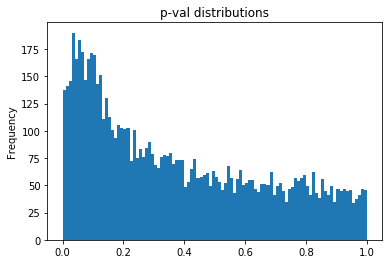

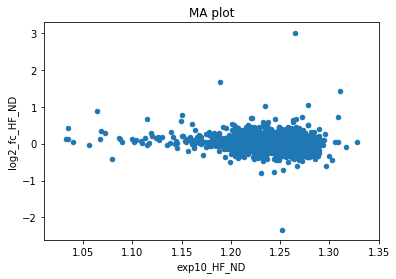

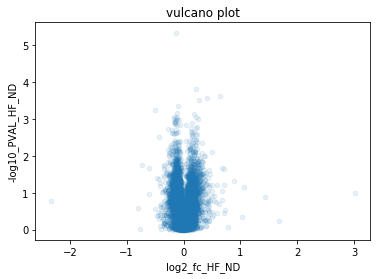

In [9]:
#t-test between normal diet and high fat diet 
from scipy.stats import ttest_ind
onesample_results = ttest_ind(norm_df[['HF_1','HF_2','HF_3']].T, norm_df[['ND_1','ND_2','ND_3']].T)
utilities.make_analysis(norm_df, onesample_results, tag='HF_ND')

In [13]:
onesample_results = ttest_ind(norm_df[['HF_1','HF_2','HF_3']].T, 
                              norm_df[['ND_1','ND_2','ND_3']].T)


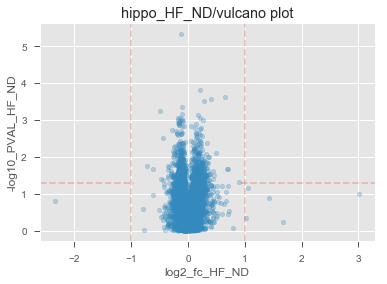

In [20]:
tag_1='HF'
tag_2='ND'
import os
tag = tag_1 +'_'+tag_2
#os.makedirs('hippo_'+tag)
sns.set(style="ticks")
from statsmodels.sandbox.stats.multicomp import multipletests
def make_analysis(norm_df, onesample_results, tag):
    plt.style.use('ggplot')
    # Set up the figure
    f, ax = plt.subplots()
    #ax.set_aspect("equal")
    # Draw the two density plots
        #correct for multy-hypotesis
    norm_df['T_'+tag]=onesample_results[0]
    norm_df['PVAL_'+tag]=onesample_results[1]         
    norm_df['-log10_PVAL_'+tag] = -np.log10(norm_df['PVAL_'+tag])
    p_adjusted = multipletests(norm_df['PVAL_'+tag], method='bonferroni')
    norm_df['PVAL_'+tag+'_ADJ']=p_adjusted[1]
    norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, alpha=0.3)
    #prot = 'sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41'
    #norm_df.loc[[prot,prot]].plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, c='r')
    
    #ax = sns.regplot(x='log2_fc_'+tag, 
                     #y='-log10_PVAL_'+tag, 
                     #data=norm_df.dropna(), ax=ax)
    
    #x=norm_df.loc[prot]['log2_fc_'+tag]-0.1
    #y=norm_df.loc[prot]['-log10_PVAL_'+tag]-0.1
    #xt = norm_df.loc[prot]['log2_fc_'+tag]-0.5
    #yt = norm_df.loc[prot]['-log10_PVAL_'+tag]-0.5
    #ax.annotate('E41L1', 

                #xy=(x, y), 
                #xytext=(xt, yt),
            #arrowprops=dict(  arrowstyle="->"),
            #)
    #norm_df = norm_df[['log2_fc_'+tag, '-log10_PVAL_'+tag]]
    #norm_df = norm_df.dropna()
    #norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, alpha=0.1,s=1,ax=ax)
    #sns.kdeplot(norm_df['log2_fc_'+tag], norm_df['-log10_PVAL_'+tag],
                 #cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    
    ax.axvline(x=1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axvline(x=-1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0, xmax=0.28, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0.6, xmax=1, ls='--',alpha=0.3)
    plt.title('hippo_'+tag+'/'+'vulcano plot')
    plt.savefig('hippo_'+tag+'/'+'vulcano.svg')
    plt.show()
    return 

onesample_results = ttest_ind(norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3']].T, 
                              norm_df[[tag_2+'_1',tag_2+'_2',tag_2+'_3']].T)
make_analysis(norm_df, onesample_results, tag=tag) 
temp = norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3',
                tag_2+'_1',tag_2+'_2',tag_2+'_3','log2_fc_'+tag,'-log10_PVAL_'+tag]]
temp = temp.sort_values('-log10_PVAL_'+tag)
temp = temp[(temp['log2_fc_'+tag]<-1) | (temp['log2_fc_'+tag]<-1)].sort_values('-log10_PVAL_'+tag)
temp.head()
temp.to_csv('hippo_'+tag+'/'+'data_'+tag+'.csv')

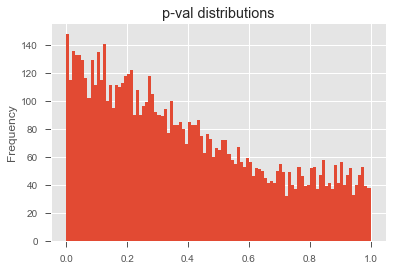

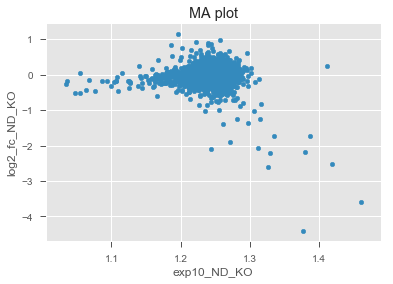

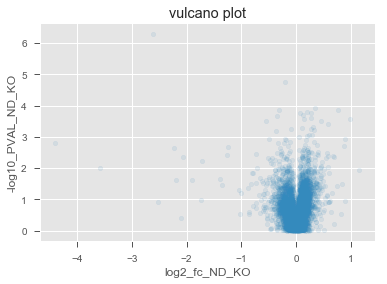

In [21]:
#t-test between normal diet and KO - high fat diet 
from scipy.stats import ttest_ind
onesample_results = ttest_ind(norm_df[['ND_1','ND_2','ND_3']].T, norm_df[['KO_1','KO_2','KO_3']].T)
utilities.make_analysis(norm_df, onesample_results, tag='ND_KO')


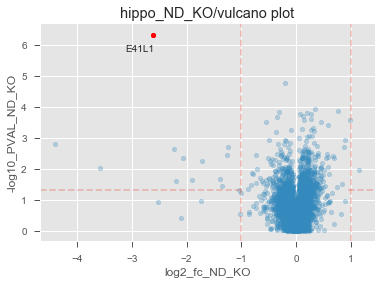

In [15]:
tag_1='ND'
tag_2='KO'
import os
tag = tag_1 +'_'+tag_2
#os.makedirs('hippo_'+tag)
sns.set(style="ticks")
from statsmodels.sandbox.stats.multicomp import multipletests
def make_analysis(norm_df, onesample_results, tag):
    plt.style.use('ggplot')
    # Set up the figure
    f, ax = plt.subplots()
    #ax.set_aspect("equal")
    # Draw the two density plots
        #correct for multy-hypotesis
    norm_df['T_'+tag]=onesample_results[0]
    norm_df['PVAL_'+tag]=onesample_results[1]         
    norm_df['-log10_PVAL_'+tag] = -np.log10(norm_df['PVAL_'+tag])
    p_adjusted = multipletests(norm_df['PVAL_'+tag], method='bonferroni')
    norm_df['PVAL_'+tag+'_ADJ']=p_adjusted[1]
    norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, alpha=0.3)
    prot = 'sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41'
    norm_df.loc[[prot,prot]].plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, c='r')
    
    #ax = sns.regplot(x='log2_fc_'+tag, 
                     #y='-log10_PVAL_'+tag, 
                     #data=norm_df.dropna(), ax=ax)
    
    x=norm_df.loc[prot]['log2_fc_'+tag]-0.1
    y=norm_df.loc[prot]['-log10_PVAL_'+tag]-0.1
    xt = norm_df.loc[prot]['log2_fc_'+tag]-0.5
    yt = norm_df.loc[prot]['-log10_PVAL_'+tag]-0.5
    ax.annotate('E41L1', 

                xy=(x, y), 
                xytext=(xt, yt),
            #arrowprops=dict(  arrowstyle="->"),
            )
    #norm_df = norm_df[['log2_fc_'+tag, '-log10_PVAL_'+tag]]
    #norm_df = norm_df.dropna()
    #norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, alpha=0.1,s=1,ax=ax)
    #sns.kdeplot(norm_df['log2_fc_'+tag], norm_df['-log10_PVAL_'+tag],
                 #cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    
    ax.axvline(x=1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axvline(x=-1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0, xmax=0.6, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0.92, xmax=1, ls='--',alpha=0.3)
    plt.title('hippo_'+tag+'/'+'vulcano plot')
    plt.savefig('hippo_'+tag+'/'+'vulcano.svg')
    plt.show()
    return 

onesample_results = ttest_ind(norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3']].T, 
                              norm_df[[tag_2+'_1',tag_2+'_2',tag_2+'_3']].T)
make_analysis(norm_df, onesample_results, tag=tag) 
temp = norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3',
                tag_2+'_1',tag_2+'_2',tag_2+'_3','log2_fc_'+tag,'-log10_PVAL_'+tag]]
temp = temp.sort_values('-log10_PVAL_'+tag)
temp = temp[(temp['log2_fc_'+tag]<-1) | (temp['log2_fc_'+tag]<-1)].sort_values('-log10_PVAL_'+tag)
temp.head()
temp.to_csv('hippo_'+tag+'/'+'data_'+tag+'.csv')

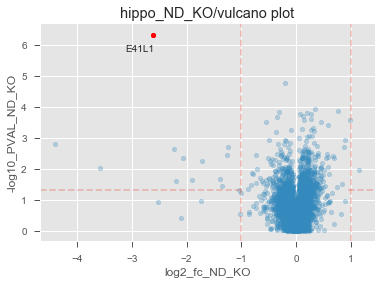

In [10]:
tag_1='ND'
tag_2='KO'
import os
tag = tag_1 +'_'+tag_2
#os.makedirs('hippo_'+tag)
sns.set(style="ticks")
from statsmodels.sandbox.stats.multicomp import multipletests
def make_analysis(norm_df, onesample_results, tag):
    plt.style.use('ggplot')
    # Set up the figure
    f, ax = plt.subplots()
    #ax.set_aspect("equal")
    # Draw the two density plots
        #correct for multy-hypotesis
    norm_df['T_'+tag]=onesample_results[0]
    norm_df['PVAL_'+tag]=onesample_results[1]         
    norm_df['-log10_PVAL_'+tag] = -np.log10(norm_df['PVAL_'+tag])
    p_adjusted = multipletests(norm_df['PVAL_'+tag], method='bonferroni')
    norm_df['PVAL_'+tag+'_ADJ']=p_adjusted[1]
    norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, alpha=0.3)
    prot = 'sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41'
    norm_df.loc[[prot,prot]].plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, c='r')
    
    #ax = sns.regplot(x='log2_fc_'+tag, 
                     #y='-log10_PVAL_'+tag, 
                     #data=norm_df.dropna(), ax=ax)
    
    x=norm_df.loc[prot]['log2_fc_'+tag]-0.1
    y=norm_df.loc[prot]['-log10_PVAL_'+tag]-0.1
    xt = norm_df.loc[prot]['log2_fc_'+tag]-0.5
    yt = norm_df.loc[prot]['-log10_PVAL_'+tag]-0.5
    ax.annotate('E41L1', 

                xy=(x, y), 
                xytext=(xt, yt),
            #arrowprops=dict(  arrowstyle="->"),
            )
    #norm_df = norm_df[['log2_fc_'+tag, '-log10_PVAL_'+tag]]
    #norm_df = norm_df.dropna()
    #norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, alpha=0.1,s=1,ax=ax)
    #sns.kdeplot(norm_df['log2_fc_'+tag], norm_df['-log10_PVAL_'+tag],
                 #cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    
    ax.axvline(x=1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axvline(x=-1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0, xmax=0.6, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0.92, xmax=1, ls='--',alpha=0.3)
    plt.title('hippo_'+tag+'/'+'vulcano plot')
    plt.savefig('hippo_'+tag+'/'+'vulcano.svg')
    plt.show()
    return 

onesample_results = ttest_ind(norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3']].T, 
                              norm_df[[tag_2+'_1',tag_2+'_2',tag_2+'_3']].T)
make_analysis(norm_df, onesample_results, tag=tag) 
temp = norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3',
                tag_2+'_1',tag_2+'_2',tag_2+'_3','log2_fc_'+tag,'-log10_PVAL_'+tag]]
temp = temp.sort_values('-log10_PVAL_'+tag)
temp = temp[(temp['log2_fc_'+tag]<-1) | (temp['log2_fc_'+tag]<-1)].sort_values('-log10_PVAL_'+tag)
temp.head()
temp.to_csv('hippo_'+tag+'/'+'data_'+tag+'.csv')

In [51]:
#print the significant one in the normalized and raw data
test = norm_df[norm_df['PVAL_ND_KO_ADJ']<0.05]
test[['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','PVAL_ND_KO_ADJ','log2_fc_ND_KO']]


,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,PVAL_ND_KO_ADJ,log2_fc_ND_KO
Fasta headers,,,,,,,,,,,
sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41,0.039689,0.039744,0.039414,0.042578,0.043624,0.052195,0.244995,0.233963,0.243161,0.003723,-2.615092


In [52]:
test = df[norm_df['PVAL_ND_KO_ADJ']<0.05]
np.log10(test[['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3']])

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3
Fasta headers,,,,,,,,,
sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41,4.956912,4.957306,4.970384,5.031812,5.050109,5.034388,5.693912,5.739731,5.717221


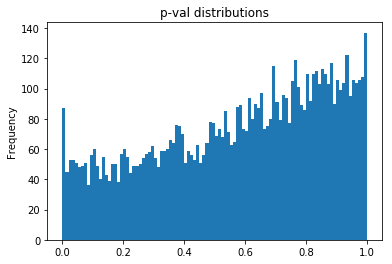

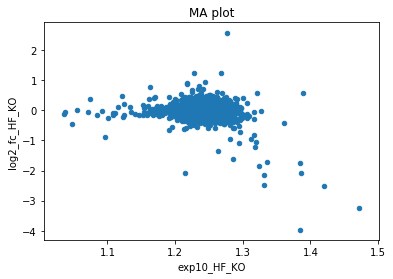

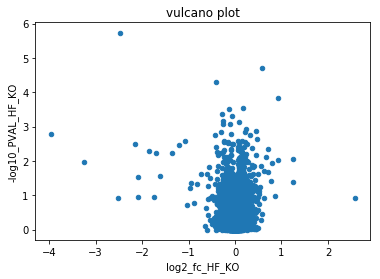

In [18]:


#t-test between high fat diet  and KO 
from scipy.stats import ttest_ind
onesample_results = ttest_ind(norm_df[['HF_1','HF_2','HF_3']].T, norm_df[['KO_1','KO_2','KO_3']].T)
utilities.make_analysis(norm_df, onesample_results, tag='HF_KO')



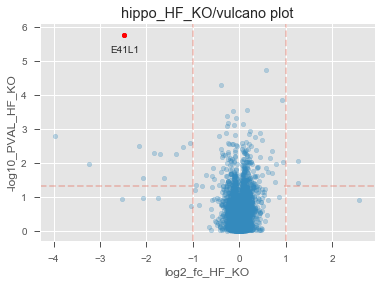

In [120]:
import os

tag_1='HF'
tag_2='KO'
tag = tag_1 +'_'+tag_2
#os.makedirs('hippo_'+tag)
sns.set(style="ticks")
from statsmodels.sandbox.stats.multicomp import multipletests
def make_analysis(norm_df, onesample_results, tag):
    plt.style.use('ggplot')
    # Set up the figure
    f, ax = plt.subplots()
    #ax.set_aspect("equal")
    # Draw the two density plots
        #correct for multy-hypotesis
    norm_df['T_'+tag]=onesample_results[0]
    norm_df['PVAL_'+tag]=onesample_results[1]         
    norm_df['-log10_PVAL_'+tag] = -np.log10(norm_df['PVAL_'+tag])
    p_adjusted = multipletests(norm_df['PVAL_'+tag], method='bonferroni')
    norm_df['PVAL_'+tag+'_ADJ']=p_adjusted[1]
    norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, alpha=0.3)
    prot = 'sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41'
    norm_df.loc[[prot,prot]].plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, ax=ax, c='r')
    
    x=norm_df.loc[prot]['log2_fc_'+tag]-0.1
    y=norm_df.loc[prot]['-log10_PVAL_'+tag]-0.1
    xt = norm_df.loc[prot]['log2_fc_'+tag]-0.3
    yt = norm_df.loc[prot]['-log10_PVAL_'+tag]-0.5
    ax.annotate('E41L1', 

                xy=(x, y), 
                xytext=(xt, yt),
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            )
    #norm_df = norm_df[['log2_fc_'+tag, '-log10_PVAL_'+tag]]
    #norm_df = norm_df.dropna()
    #norm_df.plot(kind='scatter',x='log2_fc_'+tag,y='-log10_PVAL_'+tag, alpha=0.1,s=1,ax=ax)
    #sns.kdeplot(norm_df['log2_fc_'+tag], norm_df['-log10_PVAL_'+tag],
                 #cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    
    ax.axvline(x=1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axvline(x=-1, ymin=0, ymax=1, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0, xmax=0.46, ls='--',alpha=0.3)
    ax.axhline(y=-np.log10(0.05), xmin=0.73, xmax=1, ls='--',alpha=0.3)
    plt.title('hippo_'+tag+'/'+'vulcano plot')
    plt.savefig('hippo_'+tag+'/'+'vulcano.svg')
    plt.show()
    return 

onesample_results = ttest_ind(norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3']].T, 
                              norm_df[[tag_2+'_1',tag_2+'_2',tag_2+'_3']].T)
make_analysis(norm_df, onesample_results, tag=tag) 
temp = norm_df[[tag_1+'_1',tag_1+'_2',tag_1+'_3',
                tag_2+'_1',tag_2+'_2',tag_2+'_3','log2_fc_'+tag,'-log10_PVAL_'+tag]]
temp = temp.sort_values('-log10_PVAL_'+tag)
temp = temp[(temp['log2_fc_'+tag]<-1) | (temp['log2_fc_'+tag]<-1)].sort_values('-log10_PVAL_'+tag)
temp.head()
temp.to_csv('hippo_'+tag+'/'+'data_'+tag+'.csv')

In [19]:
#print the significant one in the normalized and raw data
test = norm_df[norm_df['PVAL_HF_KO_ADJ']<0.05]
test[['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','PVAL_HF_KO_ADJ','log2_fc_HF_KO']]


,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,PVAL_HF_KO_ADJ,log2_fc_HF_KO
Fasta headers,,,,,,,,,,,
sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41,0.039689,0.039744,0.039414,0.042578,0.043624,0.052195,0.244995,0.233963,0.243161,0.013663,-2.478722


In [16]:
test = df[norm_df['PVAL_HF_KO_ADJ']<0.05]
np.log10(test[['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3']])

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3
Fasta headers,,,,,,,,,
sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41,4.956912,4.957306,4.970384,5.031812,5.050109,5.034388,5.693912,5.739731,5.717221


In [17]:
norm_df.to_csv('hippo_norm.csv')

In [22]:
prot = 'sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41'
df.loc[prot]

ND_1     90555.0
ND_2     90637.0
ND_3     93408.0
HF_1    107600.0
HF_2    112230.0
HF_3    108240.0
KO_1    494210.0
KO_2    549200.0
KO_3    521460.0
null    185250.0
Name: sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1 PE=1 SV=2;sp|Q9Z2H5-2|E41L1_MOUSE Isoform 2 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41l1;sp|Q9Z2H5-3|E41L1_MOUSE Isoform 3 of Band 4.1-like protein 1 OS=Mus musculus GN=Epb41, dtype: float64